# Create Lambda Functions and Step Function

In [1]:
IAM_ROLE = "arn:aws:iam::995409147735:role/fady_execution_role"
BUCKET = "fady-aws-project-2-20211224"

In [2]:
test_data = {
  "image_data": "",
  "s3_bucket": BUCKET,
  "s3_key": "data/test/bicycle_s_000513.png"
}

In [ ]:
# {
#   "image_data": "",
#   "s3_bucket": "fady-aws-project-2-20211224",
#   "s3_key": "data/test/bicycle_s_000513.png"
# }

## Deploy Lambda Functions

In [3]:
import base64
import io
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [4]:
import boto3
from sagemaker import get_execution_role
from zipfile import ZipFile
import os

client = boto3.client('lambda')

In [126]:
# A helper function to automate creation of lambdas
def create_lambda(function_name, lambda_file):
    zip_file = 'code.zip'

    with ZipFile(zip_file, 'w') as f:
        f.write(lambda_file, arcname='lambda_function.py')

    # If submitting as a ZipFile, you need to insert raw data. 

    with open(zip_file, 'rb') as f:
        b_code = f.read()

    response = client.create_function(
        FunctionName=function_name,
        Runtime='python3.8',
        Handler='lambda_function.lambda_handler',
        Code={
            'ZipFile': b_code,
        },
        Description='string',
        Timeout=60,
        MemorySize=1024,
        Publish=True,
        PackageType='Zip',
        Role=IAM_ROLE,
        Architectures=['x86_64']
    )

    os.remove(zip_file)

In [ ]:
create_lambda('project2_lambda1', 'lambdas/lambda_1.py')

In [127]:
create_lambda('project2_lambda3', 'lambdas/lambda_3.py')

### Lambda 2

> Note: This function should use the same verison and architecture that you used to compile the packages

In [115]:
# %%bash
# cd lambdas/lambda_2/package/
# zip -r ../deployment-package.zip .

Scanning files 
  adding: attr/ (stored 0%)
  adding: attr/converters.py (deflated 67%)
  adding: attr/converters.pyi (deflated 54%)
  adding: attr/exceptions.py (deflated 64%)
  adding: attr/exceptions.pyi (deflated 58%)
  adding: attr/filters.py (deflated 62%)
  adding: attr/filters.pyi (deflated 47%)
  adding: attr/py.typed (stored 0%)
  adding: attr/setters.py (deflated 62%)
  adding: attr/setters.pyi (deflated 52%)
  adding: attr/validators.py (deflated 78%)
  adding: attr/validators.pyi (deflated 70%)
  adding: attr/_cmp.py (deflated 66%)
  adding: attr/_cmp.pyi (deflated 55%)
  adding: attr/_compat.py (deflated 68%)
  adding: attr/_config.py (deflated 59%)
  adding: attr/_funcs.py (deflated 77%)
  adding: attr/_make.py (deflated 75%)
  adding: attr/_next_gen.py (deflated 66%)
  adding: attr/_version_info.py (deflated 63%)
  adding: attr/_version_info.pyi (deflated 56%)
  adding: attr/__init__.py (deflated 57%)
  adding: attr/__init__.pyi (deflated 80%)
  adding: attr/__pycache__

In [137]:
%%bash
cd lambdas/lambda_2
zip -g deployment-package.zip lambda_function.py

updating: lambda_function.py (deflated 50%)


In [142]:
os.environ["DEFAULT_S3_BUCKET"] = BUCKET
!aws s3 cp ./lambdas/lambda_2/deployment-package.zip s3://${DEFAULT_S3_BUCKET}/lambdas/lambda_2/deployment-package.zip

upload: lambdas/lambda_2/deployment-package.zip to s3://fady-aws-project-2-20211224/lambdas/lambda_2/deployment-package.zip


In [143]:
response = client.create_function(
    FunctionName='project2_lambda2',
    Runtime='python3.8',
    Handler='lambda_function.lambda_handler',
    Code={
        'S3Bucket' : BUCKET,
        'S3Key': f"lambdas/lambda_2/deployment-package.zip",
    },
    Description='string',
    Timeout=60,
    MemorySize=1024,
    Publish=True,
    PackageType='Zip',
    Role=IAM_ROLE,
    Architectures=['x86_64']
)

## Testing Lambda Functions

In [22]:
import boto3
#from sagemaker import get_execution_role ## The SageMaker role executing your notebook needs to have Lambda permissions. 
import json

client = boto3.client('lambda')

In [23]:
def plot_base64(base64_image):
    image = mpimg.imread(
                        io.BytesIO(base64.b64decode(base64_image)),
                        format='JPG'
                        )
    plt.imshow(image, interpolation='nearest')
    plt.show()


In [144]:
def display_response(response_json):
    plot_base64(response_json['body']['image_data'])
    print("Inferences: " + str(response_json['body']['inferences']))

In [145]:
def get_response(function_name, payload):
    # json.dumps turns a JSON-object-like python object into a string, and .encode('utf-8') encodes the 
    # the string so that it can be properly passed to the client. 

    payload_bytes = json.dumps(payload).encode('utf-8')

    response = client.invoke(
        FunctionName=function_name,
        InvocationType='RequestResponse',
        Payload=payload_bytes
    )
    # format the response as json
    response_json = json.loads(response['Payload'].read().decode('utf-8'))
    # Plot the image
    
    return response_json

### Test Lambda 1

In [152]:
response_output_1 = get_response('project2_lambda1', test_data)

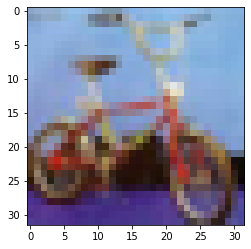

Inferences: []


In [153]:
display_response(response_output_1)

### Test Lamba 2

In [162]:
response_output_2 = get_response('project2_lambda2', response_output_1)

### Test Labmda 3

In [105]:
response_output_1['body']['inferences'] = [0.85, 0.08]
response_output_3 = get_response('project2_lambda3', response_output_1['body'])
response_output_3

{'errorMessage': 'THRESHOLD_CONFIDENCE_NOT_MET',
 'errorType': 'Exception',
 'requestId': '18cf0c82-9afb-4dcd-80a4-9037c2361408',
 'stackTrace': ['  File "/var/task/lambda_function.py", line 20, in lambda_handler\n    raise Exception("THRESHOLD_CONFIDENCE_NOT_MET")\n']}

In [113]:
json.loads(response_output_2['body'])

{'image_data': 'iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/MnkTPAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAKhUlEQVR4nF2X2ZNd1XXGf3s65873drd6UKtb6mYQCDmAIBSJ4yR2DLGLUDw5j37MH5PKn5HKSyqp4ErhymSDKSCAFUYBcgvUaqmn24PufM895+y9Vx6unIesp/2011r7W+v7vq3+7h8+lDRJsNYiKuIVJLU2uCoBhXiBIiefnNE/v4eSANHQWH6cUFsjIeCs4AFlDYl2GG0oJVICjgJTTBhNZthKjYjCB4VEAQV2NO6TO0e9XkepiBfAVvDRYhBMds6dzz8kDLpYKVhaqvDNpzf58Rs/xzeqnOUGrxI8EZFAkWpMmVMpp1TGfYaTEaMYmRaetUuXQVti0IgIIoKttDcxWkM6fwWnNGiNDgofC7y2NFZWGYmimJSMVcrmS3/FKJSszG6x0rzIpBCmeYZ2FhMsnXod7/t8cPMtxtLg2p/8NRerDXIv+ChoDSKC9x7rkhoxBlCOiAUBFSJIQCKUqkHn8g2a6wqCgA5k2jDIu7TiHuvqNmflIuOZw2Y9nM1ZXlnBJx2u3PgZvrmEcSl5iEQgiODDvABRBmuM4KxGawEpEYlEgRACiOC0wntFWUYEQSQSrMGYDoXMyGaHeLfJtL6Eczle1zgtBtRNQW2hQV+llCKgFQoh+kDEgJrDYJVSgPD78D7gvUdEUEScUSg0BghRQBQugNEpOR2OB7+jXn9ArurksoT1BudyyphB9KgYCb+/XIFSBhEAQWuNBYhRgEiMkbIsiTEiAtaoeSFKcNaioqAMKAJETWEWOMu2aJ/usbq6gElKpDjBkNAb1ylNjSKUqJjM8yuIQSES/69hKyKPEgri

In [112]:
response_output_3 = get_response('project2_lambda3', json.loads(response_output_2['body']))
response_output_3

{'errorMessage': "'>' not supported between instances of 'str' and 'float'",
 'errorType': 'TypeError',
 'requestId': '143ca858-260f-4b8d-b668-67e9e47da8e8',
 'stackTrace': ['  File "/var/task/lambda_function.py", line 13, in lambda_handler\n    meets_threshold = any([x > THRESHOLD for x in inferences]) ## TODO: fill in\n',
  '  File "/var/task/lambda_function.py", line 13, in <listcomp>\n    meets_threshold = any([x > THRESHOLD for x in inferences]) ## TODO: fill in\n']}

## Create Step Function State Machine

In [ ]:
client = boto3.client('stepfunctions')

In [ ]:
# Create the state machine using saved definition file
with open("step-function.json", 'r') as fp:
    definition = fp.read()

response = client.create_state_machine(
    name='image-classification-state-machine', # Names need to be unique. 
    definition=definition,
    roleArn=IAM_ROLE,
    type='STANDARD',
    loggingConfiguration={
        'level': 'OFF'
    }
)
print(response)

In [ ]:
# Execute the state machine
response = client.start_execution(
    stateMachineArn='arn:aws:states:us-east-1:995409147735:stateMachine:image-classification-state-machine', # You can find this through the Console or through the 'response' object. 
    name='example1', # Execution names need to be unique within state machines. 
    input=test_data # Input needs to be at least empty brackets. 
)